# CASH-4378: Build ARIMA Forecast strategy Guideline

## Part 2: Extarct market trends:

In [1]:
# Load required packages
import matplotlib
from pricing_analysis_utils import read_cached_sql
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns

sns.set()

## ARIMA/SARIMAX
from math import sqrt

# import necessary libraries
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from datetime import timedelta

## Chart options
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Supressing warnings
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Format settings:
pd.set_option("display.float_format", lambda x: "%.4f" % x)

### Get TRAC rates from selected lanes V0 

TRAC lanes were originally denified on CASH-4305:

You can either extract then from a s3 file or trino table.

In [3]:
# ## Extract files from aws S3 and save it on a file path
# ! aws s3 cp  s3://loadsmart-data-science/pricing-analysis/CASH-4305/df_trac_selected_lanes_rates.csv .

### Table trino: s3_silver.trac.lanes

In [4]:
## Get selected Dry Van lanes previously defined
df_trac = pd.read_csv("df_trac_selected_lanes_rates.csv")
df_trac.set_index("data_timestamp", inplace=True)

## fill in missing data
df_trac = df_trac.fillna(method="ffill").fillna(method="bfill")

## Select a few lanes to run ARIMA:

#### The chosen lanes are among the SG TOP Lanes previously identified

In [5]:
df_arima = df_trac[
    [
        "442-286",
        "410-601",
        "917-841",
        "770-300",
        "432-296",
        "301-945",
        "231-194",
        "372-282",
        "780-770",
        "303-752",
    ]
]
# df_arima = df_trac[["442-286", "410-601", "917-841", "770-300"]]
df_arima.index = pd.to_datetime(df_arima.index)

# Get datapoints of every Friday
df_arima_f = df_arima[df_arima.index.day_name() == "Friday"]

### Time-series chart visualization

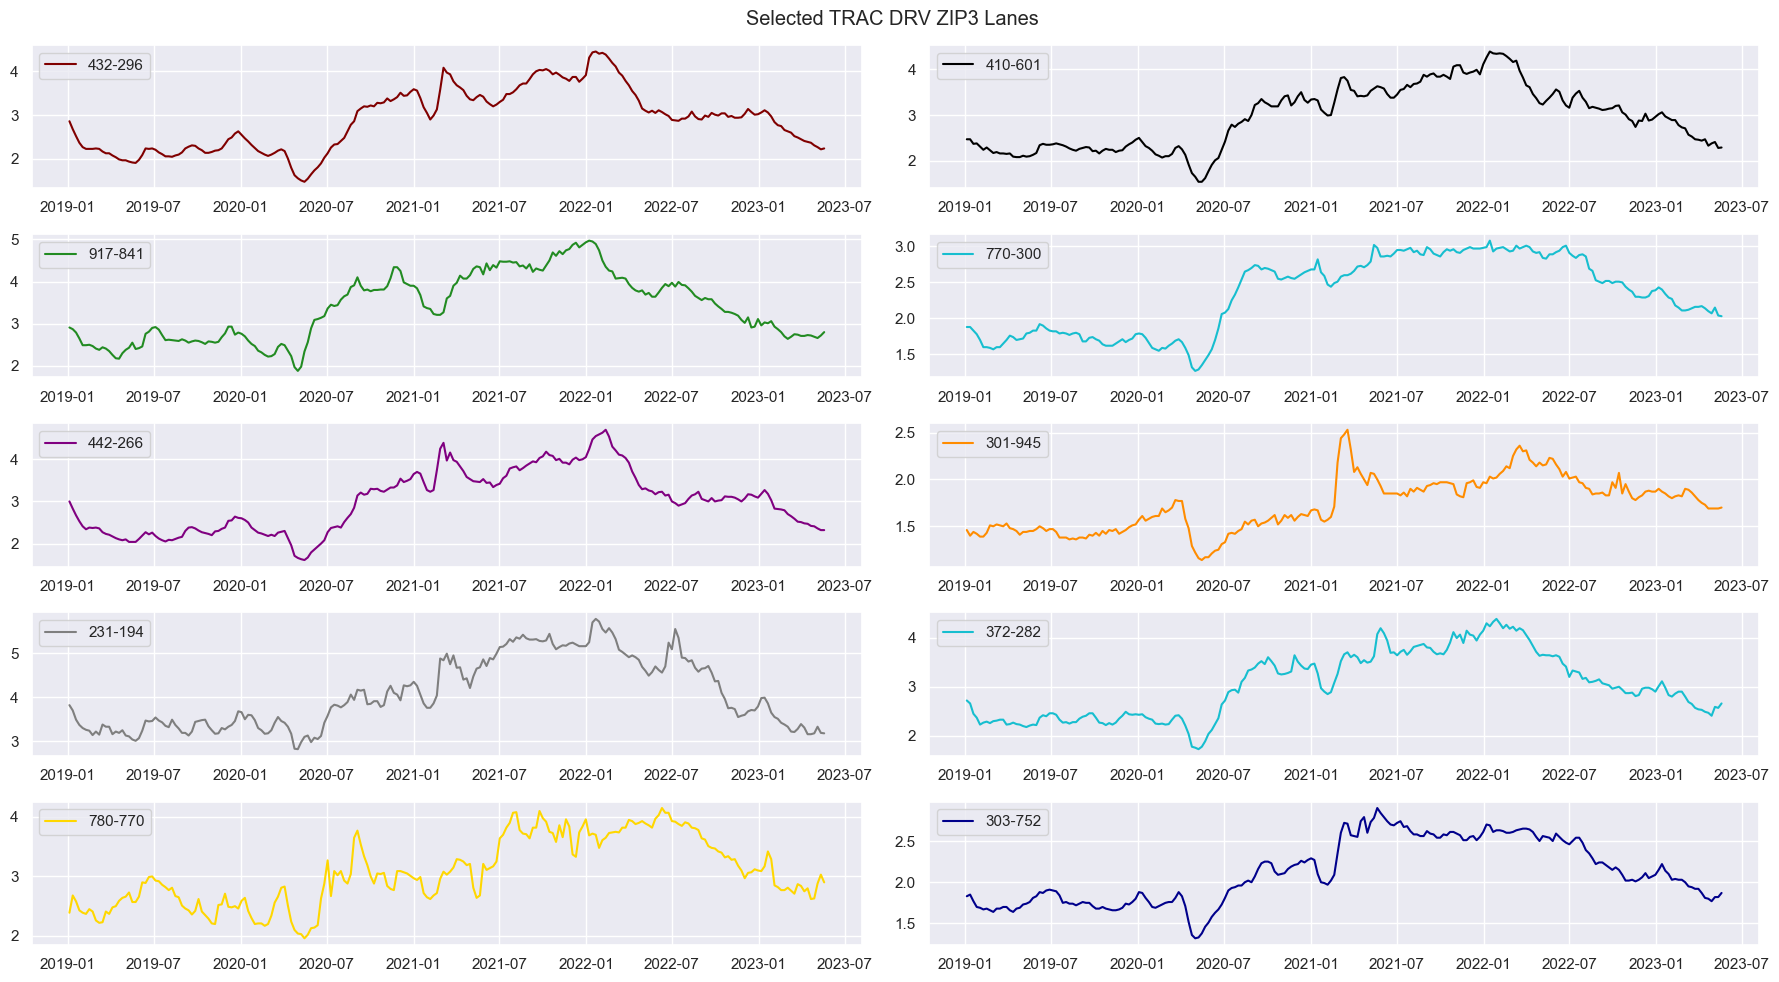

In [6]:
fig = plt.figure(figsize=(18, 10))

plt.suptitle("Selected TRAC DRV ZIP3 Lanes")
ax1 = fig.add_subplot(5, 2, 1)
ax1.plot(df_arima_f["432-296"], label="432-296", color="maroon")
plt.legend()
# lane 2
ax2 = fig.add_subplot(5, 2, 2)
ax2.plot(df_arima_f["410-601"], label="410-601", color="black")
plt.legend()

# Lane 3
ax3 = fig.add_subplot(5, 2, 3)
ax3.plot(df_arima_f["917-841"], label="917-841", color="forestgreen")
plt.legend()
# Lane 4
ax4 = fig.add_subplot(5, 2, 4)
ax4.plot(df_arima_f["770-300"], label="770-300", color="tab:cyan")
plt.legend()

# Lane 5
ax5 = fig.add_subplot(5, 2, 5)
ax5.plot(df_arima_f["442-286"], label="442-266", color="purple")
plt.legend()
# Lane 6
ax6 = fig.add_subplot(5, 2, 6)
ax6.plot(df_arima_f["301-945"], label="301-945", color="darkorange")
plt.legend()

# Lane 7
ax7 = fig.add_subplot(5, 2, 7)
ax7.plot(df_arima_f["231-194"], label="231-194", color="tab:gray")
plt.legend()
# Lane 8
ax8 = fig.add_subplot(5, 2, 8)
ax8.plot(df_arima_f["372-282"], label="372-282", color="tab:cyan")
plt.legend()

# Lane 9
ax9 = fig.add_subplot(5, 2, 9)
ax9.plot(df_arima_f["780-770"], label="780-770", color="gold")
plt.legend()
# Lane 10
ax10 = fig.add_subplot(5, 2, 10)
ax10.plot(df_arima_f["303-752"], label="303-752", color="darkblue")
plt.legend()


[ax.legend(loc=2) for ax in plt.gcf().axes]

plt.tight_layout()

plt.show()

## ARIMA (p,d,q) Autoregressive Integrated Moving Average

$ y_t = c + \sum_{i=1}^{p}\beta_i y_{t-i} + \sum_{i=1}^{q}\theta_i \epsilon_{t-i} $


ARIMA models combine three distinct components:

* Autoregression (AR $ \rightarrow p$)
* Differencing (I $ \rightarrow d$) 
* Moving average (MA $ \rightarrow q$)

The autoregressive component captures the relationship between an observation and a predetermined number of lagged observations. Meanwhile, differencing is used to make a non-stationary time series stationary. And finally, the moving average component accounts for the impact of past errors on the current observation.

One can think the constant term $c$ as the long-term path of the series; 

Since I am looking for short-term forecasts, I do not need to woory with seasonal patterns (calendar effects). Besides, if some one decideds to evaluate a ACF function to see if there is any seasonal pattern, graphical analysis does not indicate the presence of this effect.

#### Forecasting:
It extrapolates the local trend at the end of the series but flattens it out at longer forecast horizons to introduce a note of conservatism, a practice that has empirical support

## ARIMA Modelling:

### Let's loop ARIMA for all selected lanes

In [7]:
def get_forecast_lane(data, n_periods):
    # Initialize empty lists to store forecast data
    data_fc = []
    data_lower = []
    data_upper = []
    data_aic = []
    data_order = []
    data_fitted = []

    # Iterate over columns in data
    for lane in data.columns:
        # Fit an ARIMA model using the auto_arima function
        data_actual = data[lane]
        model = pm.auto_arima(
            data_actual,
            start_p=0,
            start_q=0,
            max_p=5,
            max_q=5,  # maximum p and q
            test="adf",  # use adftest to find optimal 'd'
            d=None,  # let model determine 'd'
            #   seasonal=seasonal,  # TRUE if seasonal series
            # m=7,  # frequency of series
            # D=None,  # let model determine 'D'
            trace=False,
            error_action="ignore",
            suppress_warnings=True,
            stepwise=True,
        )

        # Generate forecast and confidence intervals for n_periods into the future
        fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
        index_of_fc = pd.date_range(
            pd.to_datetime(df_arima_f.index[-1]) + timedelta(days=6),
            periods=n_periods,
            freq="W-FRI",
        )

        # Append forecast data to lists
        data_fc.append(fc)
        data_lower.append(confint[:, 0])
        data_upper.append(confint[:, 1])
        data_aic.append(model.aic())
        data_order.append(model.order)
        data_fitted.append(
            model.fittedvalues()
        )  # Notice that auto arima applies one-step ahead predictions

        # Create dataframes for forecast, lower bound, and upper bound and model statistics
        df_fc = pd.DataFrame(index=index_of_fc)
        df_lower = pd.DataFrame(index=index_of_fc)
        df_upper = pd.DataFrame(index=index_of_fc)
        df_aic = pd.DataFrame()
        df_order = pd.DataFrame()
        df_fitted = pd.DataFrame(index=data_actual.index)

    # Populate dataframes with fit results
    i = 0
    for lane in data.columns:
        df_fc[lane] = data_fc[i][:]
        df_lower[lane] = data_lower[i][:]
        df_upper[lane] = data_upper[i][:]
        df_aic[lane] = data_aic[i]
        df_order[lane] = data_order[i]
        df_fitted[lane] = data_fitted[i][:].iloc[1:]
        i = i + 1

    # Need to drop first row of fitted data - all row value equals to zero because of the recursive ARIMA process
    df_fitted = df_fitted.iloc[1:]
    # Rename df_order index to match ARI<MA hyperparamethers
    df_order = df_order.rename(index={0: "p", 1: "d", 2: "q"})

    return df_fc, df_lower, df_upper, df_aic, df_fitted, df_order

In [8]:
def get_combined_data(df_actual, df_forecast):
    # Assign input data to separate variables
    data_actual = df_actual
    data_forecast = df_forecast

    # Add a 'desc' column to indicate whether the data is actual or forecast
    data_actual["desc"] = "Actual"
    data_forecast["desc"] = "Forecast"

    # Combine actual and forecast data into a single DataFrame and reset the index
    df_act_fc = pd.concat([data_actual, data_forecast]).reset_index()

    # Rename the index column to 'month'
    df_act_fc = df_act_fc.rename(columns={"index": "date"})
    df_act_fc = df_act_fc.set_index("date")
    # Return the combined DataFrame
    return df_act_fc

In [9]:
df_fc, df_lower, df_upper, df_aic, df_fitted, df_order = get_forecast_lane(
    data=df_arima_f, n_periods=1
)

### Best model selection based on AIC Criteria

In [10]:
df_order

,442-286,410-601,917-841,770-300,432-296,301-945,231-194,372-282,780-770,303-752
p,1,3,3,2,1,5,0,2,0,5
d,1,1,1,1,1,1,1,1,1,1
q,2,0,0,0,0,0,0,1,0,1


Noticed that because all series were non-stationary, they all need to be differentiated (shifht(1) - d=1)). 

### Combined actual and forecasted (one-week ahead data points

In [11]:
df_act_fc = get_combined_data(df_actual=df_arima_f, df_forecast=df_fc)
df_act_fc

,442-286,410-601,917-841,770-300,432-296,301-945,231-194,372-282,780-770,303-752,desc
date,,,,,,,,,,,
2019-01-04,3.0000,2.4700,2.9100,1.8800,2.8600,1.4600,3.8200,2.7200,2.3900,1.8300,Actual
2019-01-11,2.8300,2.4700,2.8700,1.8800,2.6800,1.4000,3.7000,2.6600,2.6800,1.8500,Actual
2019-01-18,2.6700,2.3700,2.7900,1.8300,2.5200,1.4400,3.4900,2.4500,2.5800,1.7700,Actual
2019-01-25,2.5300,2.3800,2.6500,1.7800,2.3700,1.4200,3.3700,2.3700,2.4300,1.7000,Actual
2019-02-01,2.4100,2.3100,2.4900,1.7000,2.2700,1.3900,3.3000,2.2300,2.3900,1.6900,Actual
...,...,...,...,...,...,...,...,...,...,...,...
2023-04-28,2.4100,2.3800,2.6900,2.0700,2.3100,1.6900,3.1800,2.4100,2.6300,1.7700,Actual
2023-05-05,2.3600,2.4100,2.6600,2.1500,2.2700,1.6900,3.3300,2.5900,2.8800,1.8200,Actual
2023-05-12,2.3200,2.2800,2.7200,2.0400,2.2200,1.6900,3.1900,2.5700,3.0300,1.8200,Actual


### Error metrics

In [13]:
# Calculkate key error metrics - Compare actual data vs fitted data

mse = ((df_arima_f - df_fitted) ** 2).mean(axis=0)
rmse = np.sqrt(mse)
rmse = pd.DataFrame({"lane": rmse.index, "RMSE": rmse.values})[:-1]

mae = abs((df_arima_f - df_fitted)).mean(axis=0)
mae = pd.DataFrame({"lane": mae.index, "MAE": mae.values})[:-1]

mape = abs((df_arima_f - df_fitted) / df_arima_f).mean(axis=0)
mape = pd.DataFrame({"lane": mape.index, "MAPE": mape.values})[:-1]

mspe = (((df_arima_f - df_fitted) ** 2) / df_arima_f).mean()
rmspe = np.sqrt(mspe)
rmspe = pd.DataFrame({"lane": rmspe.index, "RMSPE": rmspe.values})[:-1]

error_metrics = pd.merge(
    pd.merge(pd.merge(mape, mae, on="lane"), rmse, on="lane"), rmspe, on="lane"
)
error_metrics

,lane,MAPE,MAE,RMSE,RMSPE
0,231-194,0.0261,0.1052,0.1469,0.0713
1,301-945,0.0233,0.0410,0.0611,0.0444
2,303-752,0.0165,0.0350,0.0493,0.0331
3,372-282,0.0226,0.0683,0.0913,0.0514
4,410-601,0.0212,0.0612,0.0830,0.0479
5,432-296,0.0181,0.0532,0.0761,0.0424
6,442-286,0.0209,0.0628,0.0897,0.0496
7,770-300,0.0169,0.0376,0.0523,0.0345
8,780-770,0.0355,0.1062,0.1547,0.0887
9,917-841,0.0229,0.0743,0.0975,0.0541


### Evaluate ARIMA market trend

In [238]:
### Set market directional trends
def market_trend(x):
    if x >= 0.015:
        return "up"
    if x <= -0.015:
        return "down"
    else:
        return "stable"

In [239]:
df_direc = df_act_fc.tail(2)
df_direc

,442-286,410-601,917-841,770-300,432-296,301-945,231-194,372-282,780-770,303-752,desc
date,,,,,,,,,,,
2023-05-19,2.3200,2.2900,2.8000,2.0300,2.2400,1.7000,3.1800,2.6600,2.9000,1.8700,Actual
2023-05-26,2.3324,2.2700,2.8406,2.0128,2.2515,1.7063,3.1800,2.6607,2.9000,1.8895,Forecast


In [240]:
## Exclude desc column
df_direc = df_direc.iloc[:, :-1]
## Calculate difference betwen last actual value and one--step ahead forecast
df_delta = df_direc.diff()
# Drop the first row
df_delta = df_delta.iloc[1:]
df_delta

,442-286,410-601,917-841,770-300,432-296,301-945,231-194,372-282,780-770,303-752
date,,,,,,,,,,
2023-05-26,0.0124,-0.0200,0.0406,-0.0172,0.0115,0.0063,0.0000,0.0007,0.0000,0.0195


In [241]:
df_delta_trend = df_delta.applymap(market_trend)
df_delta_trend

,442-286,410-601,917-841,770-300,432-296,301-945,231-194,372-282,780-770,303-752
date,,,,,,,,,,
2023-05-26,stable,down,up,down,stable,stable,stable,stable,stable,up


## Out-of-sanple market trend evaluation

Since we have rates until 2023-05-19, let's see how the models beve in terms of forecasting out-of-sample values. This will also help us validate the forecasted strategy.
Thus, we compare forecasted values with real TRAC (real) rates

In [231]:
### Run curl to extract TRAC rpm rates for selected lanes

df_trac = pd.DataFrame(
    {
        "442-286": [2.29],
        "410-601": [2.37],
        "917-841": [2.95],
        "770-300": [2.01],
        "432-296": [2.24],
        "301-945": [1.69],
        "231-194": [3.35],
        "372-282": [2.67],
        "780-770": [2.91],
        "303-752": [1.90],
    }
)

df_trac.index = df_fc.index

In [232]:
df_direc

,442-286,410-601,917-841,770-300,432-296,301-945,231-194,372-282,780-770,303-752
date,,,,,,,,,,
2023-05-19,2.3200,2.2900,2.8000,2.0300,2.2400,1.7000,3.1800,2.6600,2.9000,1.8700
2023-05-26,2.3324,2.2700,2.8406,2.0128,2.2515,1.7063,3.1800,2.6607,2.9000,1.8895


In [233]:
## Drop the forecast row (2023-05-26)
df_direc_trac = df_direc[:-1]
## Merge with TRAC rates (real values)
data = [df_direc_trac, df_trac]
df_direc_trac = pd.concat(data)

In [242]:
## Calculate difference betwen last actual value and one--step ahead forecast
df_delta_trac = df_direc_trac.diff()
# Drop the first row
df_delta_trac = df_delta_trac.iloc[1:]

## Get TRAC market trend
df_delta_trac_trend = df_delta_trac.applymap(market_trend)
df_delta_trac_trend.index.name = "date"
df_delta_trac_trend

,442-286,410-601,917-841,770-300,432-296,301-945,231-194,372-282,780-770,303-752
date,,,,,,,,,,
2023-05-26,down,up,up,down,stable,stable,up,stable,stable,up


### Now let's compared market trends: ARIMA vs TRAC

In [245]:
compared_df = df_delta_trend.compare(
    df_delta_trac_trend, keep_shape=True, keep_equal=True
)

stacked = compared_df.stack()

stacked = stacked.rename(index={"self": "ARIMA", "other": "TRAC"})
stacked = stacked.reset_index()

stacked = stacked.rename(columns={"level_1": "Strategy"}).drop(columns=["date"])
stacked = stacked.set_index("Strategy")
stacked

,442-286,410-601,917-841,770-300,432-296,301-945,231-194,372-282,780-770,303-752
Strategy,,,,,,,,,,
ARIMA,stable,down,up,down,stable,stable,stable,stable,stable,up
TRAC,down,up,up,down,stable,stable,up,stable,stable,up


### Conclusions:

* On both startegies, stable enviroment was the major class;
  
* The worst scenario, where the market trend diverges (up-down) happened in only one of the cases.

* The ARIMA strategy successfully identified 70% of the real market trend;
  
* Where the answers match (7 out of 10), roughly: 55% are stable, 30% ups and 15% down.
  * Notice that this distribution is influenced by sample size and market conditions. Hence, this relationship may change as the set of lanes, market conditions and business goals evolves.
